In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

I0617 09:09:08.459761 11720 file_utils.py:39] PyTorch version 1.5.0 available.
I0617 09:09:11.856180 11720 file_utils.py:55] TensorFlow version 2.0.0 available.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
df = pd.read_csv('reviews.csv')

In [8]:
df = df.iloc[700:900,:]

In [9]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(to_sentiment)

In [10]:
class_names = ['negative', 'neutral', 'positive']


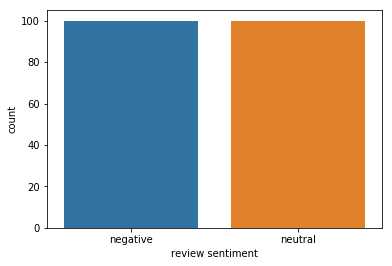

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0617 09:11:17.200367 11720 tokenization_utils.py:1022] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at C:\Users\Hiep Nguyen/.cache\torch\transformers\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [14]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'


In [15]:
tokens = tokenizer.tokenize(sample_txt)


In [16]:
tokens

['When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.']

In [17]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id


('[CLS]', 101)

In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [21]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
700,Joan Casals,https://lh3.googleusercontent.com/-Em2ppgdQ6Ug...,"On the phone it works perfectly, but now that ...",3,3,4.15.9.6,2019-10-17 08:42:43,"Hi, that's a little strange, please send us a ...",2019-10-19 15:13:39,newest,com.anydo,1
701,Julieta Correa,https://lh3.googleusercontent.com/a-/AOh14GifZ...,"I used this app for a long time. But now, I do...",3,0,4.15.9.6,2019-10-16 13:35:15,If you're experiencing issues with your remind...,2019-10-19 13:59:08,newest,com.anydo,1
702,Temp Test,https://lh3.googleusercontent.com/-4BJ-9iC8p8Q...,Working great so far until my Nokia 8.1 was fo...,3,4,4.15.9.6,2019-10-15 13:13:05,"Hi, due to Android Q limitations pop up notifi...",2019-10-17 07:04:37,newest,com.anydo,1
703,Bharat Gupta,https://lh3.googleusercontent.com/a-/AOh14GhsL...,"Too many crashes over the past few months, esp...",3,0,4.15.9.6,2019-10-12 15:46:21,"Hi, that's odd, please send us a bug report in...",2019-10-16 08:28:03,newest,com.anydo,1
704,Edvinas Masliukovas,https://lh3.googleusercontent.com/a-/AOh14Ghev...,A good app but does not show full month tasks ...,3,1,4.15.9.6,2019-10-12 07:38:21,"Hi, that sounds a little strange, please send ...",2019-10-16 08:22:17,newest,com.anydo,1


In [24]:
class get_data(Dataset):
    
    def __init__(self,reviews,targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens= True,
        max_length= self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask= True,
        return_tensors ='pt'
        )
        
        return {
            "review_test" : review,
            "input_ids": encoding['input_ids'].flatten(),
            "attention_mask" : encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target,dtype=torch.long)
        }

In [25]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=2020
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state= 2020
)

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds = get_data(
    reviews = df.content.to_numpy(),
    targets = df.sentiment.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
    )
    
    return DataLoader(ds,batch_size=batch_size, num_workers= 0
                     )

In [27]:
BATCH_SIZE = 8
MAX_LEN = 100
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

I0617 09:11:28.652798 11720 configuration_utils.py:265] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\Hiep Nguyen/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0617 09:11:28.652798 11720 configuration_utils.py:301] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0617 09:11:29.149083 11720 modeling_utils.py:650] loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin

In [29]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [30]:
last_hidden, pooled_output= bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

In [31]:
last_hidden

tensor([[[ 0.4070,  0.1858, -0.2489,  ..., -0.0298,  0.1574, -0.0787],
         [ 0.2521, -0.4902,  0.4746,  ..., -0.3883,  0.2401, -0.1347],
         [ 0.0866, -0.0274, -0.5215,  ...,  0.6011, -0.2430,  0.6801],
         ...,
         [ 0.0907,  0.1219, -0.3152,  ...,  0.0500,  0.0258,  0.2034],
         [ 0.0084,  0.2015,  0.0708,  ..., -0.0751,  0.2075, -0.0857],
         [ 0.0273,  0.2316,  0.1510,  ..., -0.1111,  0.0845, -0.1100]]],
       grad_fn=<NativeLayerNormBackward>)

In [32]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, pretrained):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained)
        self.drp = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size,n_classes)
    
    def forward(self,x, attention_mask):
        _, pooled_output = self.bert(input_ids=x, attention_mask=attention_mask)
        x = self.drp(pooled_output)
        x = self.fc(x)
        return x

In [170]:
model = SentimentClassifier(len(class_names),PRE_TRAINED_MODEL_NAME)
#model = model.to(device)

I0616 17:51:53.777407  2112 configuration_utils.py:265] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\Hiep Nguyen/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0616 17:51:53.778405  2112 configuration_utils.py:301] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0616 17:51:53.950988  2112 modeling_utils.py:650] loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin

RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 3.00 GiB total capacity; 2.05 GiB already allocated; 12.73 MiB free; 2.22 GiB reserved in total by PyTorch)

In [33]:
encoding['input_ids']

#out = model(encoding['input_ids'].cuda(), encoding['attention_mask'].cuda())

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [34]:
#torch.argmax(out)

In [38]:
def train_loop(data_loader, epochs=10, device ='cpu'):
    model = SentimentClassifier(len(class_names),PRE_TRAINED_MODEL_NAME)
    model = model.to(device)
    optimizer = AdamW(model.parameters(),lr=2e-5, correct_bias=False)
    steps = len(train_data_loader) * epochs
    
    scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps= steps)
    
    loss_func = nn.CrossEntropyLoss().to(device)
    model.train()
    
    for epoch in range(epochs):
        losses = []
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids,
                           attention_mask = attention_mask)
            preds = torch.argmax(outputs)
            loss = loss_func(outputs,targets)
            print(loss)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        print('-'*40)
        print('loss at epoch {} is {}'.format(epoch,np.mean(losses)))
    model.eval()
    return model

In [49]:
model = train_loop(train_data_loader)

I0617 10:01:19.640799 11720 configuration_utils.py:265] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at C:\Users\Hiep Nguyen/.cache\torch\transformers\b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0617 10:01:19.642799 11720 configuration_utils.py:301] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

I0617 10:01:20.129968 11720 modeling_utils.py:650] loading weights file https://cdn.huggingface.co/bert-base-cased-pytorch_model.bin

tensor(1.0062, grad_fn=<NllLossBackward>)
tensor(0.8180, grad_fn=<NllLossBackward>)
tensor(0.8943, grad_fn=<NllLossBackward>)
tensor(0.9292, grad_fn=<NllLossBackward>)
tensor(0.9147, grad_fn=<NllLossBackward>)
tensor(0.7970, grad_fn=<NllLossBackward>)
tensor(0.8519, grad_fn=<NllLossBackward>)
tensor(0.9423, grad_fn=<NllLossBackward>)
tensor(0.8198, grad_fn=<NllLossBackward>)
tensor(0.7753, grad_fn=<NllLossBackward>)
tensor(1.0076, grad_fn=<NllLossBackward>)
tensor(0.8583, grad_fn=<NllLossBackward>)
tensor(0.8170, grad_fn=<NllLossBackward>)
tensor(0.7819, grad_fn=<NllLossBackward>)
tensor(0.8377, grad_fn=<NllLossBackward>)
tensor(0.7108, grad_fn=<NllLossBackward>)
tensor(0.7284, grad_fn=<NllLossBackward>)
tensor(0.8697, grad_fn=<NllLossBackward>)
tensor(0.5712, grad_fn=<NllLossBackward>)
tensor(0.7965, grad_fn=<NllLossBackward>)
tensor(0.9091, grad_fn=<NllLossBackward>)
tensor(0.6472, grad_fn=<NllLossBackward>)
tensor(0.8568, grad_fn=<NllLossBackward>)
----------------------------------

tensor(0.0012, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)
----------------------------------------
loss at epoch 7 is 0.2895006903054309
tensor(0.0012, grad_fn=<NllLossBackward>)
tensor(0.0013, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0013, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)
tensor(0.0014, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0011, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)
tensor(0.0012, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward

In [72]:
encoding = tokenizer.encode_plus(
  'very nice and brilliant and cool',
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [73]:
torch.argmax(model(encoding['input_ids'],encoding['attention_mask']))

tensor(2, grad_fn=<NotImplemented>)